In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import json

import seaborn as sns # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
from collections import defaultdict

from sklearn.model_selection import train_test_split, KFold # type: ignore
from sklearn.metrics import confusion_matrix # type: ignore

import hmmlearn.hmm as hmm
from preprocessing import get_mfcc
from utils import get_all_words

In [484]:
class_names = get_all_words(tiny=True)
n_states = 3
states = np.ones(len(class_names), dtype=int) * n_states
n_mix = 6

In [485]:
dataset_path = '../datasets/split'

model_path = '../models'

In [486]:
def load_data(dataset_path: str, class_names: str):
    length = 0
    for cn in class_names:
        length += len(os.listdir(f"{dataset_path}/{cn}"))
    print('Total samples:', length)

    X = {'train': {}, 'test': {}}
    y = {'train': {}, 'test': {}}

    all_data = {}
    all_labels = {}
    for cname in class_names:
        file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
            os.path.join(dataset_path, cname)) if i.endswith('.wav')]
        data = [get_mfcc(file_path) for file_path in file_paths]
        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]

    for cname in class_names:
        x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.33,
            random_state=42
        )

        X['train'][cname] = x_train
        X['test'][cname] = x_test
        y['test'][cname] = y_test

    total_train = 0
    total_test = 0
    for cname in class_names:
        train_count = len(X['train'][cname])
        test_count = len(X['test'][cname])
        print(cname, 'train:', train_count, '| test:', test_count)
        total_train += train_count
        total_test += test_count
    print('train samples:', total_train)
    print('test samples', total_test)

    return X, y

In [487]:
X, y = load_data(dataset_path, class_names)

Total samples: 1036
chu train: 13 | test: 7
ve train: 13 | test: 7
vao train: 13 | test: 7
tai train: 13 | test: 7
dau train: 13 | test: 7
cuoi train: 13 | test: 7
ke train: 12 | test: 7
truoc train: 12 | test: 7
dung train: 13 | test: 7
ngung train: 13 | test: 7
doc train: 13 | test: 7
tiep train: 13 | test: 7
lui train: 13 | test: 7
toi train: 13 | test: 7
tang train: 13 | test: 7
to train: 13 | test: 7
giam train: 13 | test: 7
nho train: 13 | test: 7
lai train: 13 | test: 7
lap train: 13 | test: 7
nhanh train: 13 | test: 7
cham train: 13 | test: 7
luu train: 13 | test: 7
xoa train: 13 | test: 7
huy train: 13 | test: 7
chay train: 13 | test: 7
xong train: 13 | test: 7
ddung train: 13 | test: 7
sai train: 13 | test: 7
giup train: 13 | test: 7
gio train: 13 | test: 7
ngay train: 13 | test: 7
tuoi train: 13 | test: 7
co train: 13 | test: 7
khong train: 13 | test: 7
muc train: 13 | test: 7
bai train: 13 | test: 7
mot train: 13 | test: 7
hai train: 13 | test: 7
ba train: 13 | test: 7
bon 

In [488]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mix: int = 2):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx])

        # trans matrix
        print(cname)
        print(trans_matrix)
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mix,
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods

In [489]:
# def train(X: dict[str, dict], class_names: list[str], states: dict[str, int], n_mix: int = 2):
#     """
#     Hàm huấn luyện mô hình HMM cho từng từ với số trạng thái riêng biệt.
    
#     Args:
#         X (dict): Dữ liệu huấn luyện, với cấu trúc {"train": {"word": [feature_array]}}.
#         class_names (list): Danh sách các từ cần huấn luyện.
#         states (dict): Dictionary chứa số trạng thái cho từng từ.
#         n_mix (int): Số Gaussian Mixture trong GMM-HMM.

#     Returns:
#         models (dict): Dictionary chứa mô hình HMM cho từng từ.
#         likelihoods (dict): Dictionary chứa log-likelihood cho từng mô hình.
#     """
#     models = {}
#     likelihoods = {}

#     for cname in class_names:
#         if cname not in states:
#             print(f"Warning: '{cname}' không có trong danh sách trạng thái, bỏ qua...")
#             continue

#         n_states = states[cname]

#         # Khởi tạo xác suất bắt đầu và ma trận chuyển tiếp
#         start_prob = np.full(n_states, 0.0)
#         start_prob[0] = 1.0
#         trans_matrix = np.full((n_states, n_states), 0.0)
#         p = 0.5  # Xác suất chuyển tiếp
#         np.fill_diagonal(trans_matrix, p)
#         np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
#         trans_matrix[-1, -1] = 1.0  # Trạng thái cuối cùng tự chuyển tiếp
#         trans_matrix = trans_matrix / n_states  # Chuẩn hóa

#         print(f"Word: {cname}, States: {n_states}")
#         print(trans_matrix)

#         # Khởi tạo mô hình HMM
#         models[cname] = hmm.GMMHMM(
#             n_components=n_states,
#             n_mix=n_mix,
#             verbose=False,
#             n_iter=300,
#             startprob_prior=start_prob,
#             transmat_prior=trans_matrix,
#             params='stmc',
#             init_params='mc',
#             random_state=42
#         )

#         # Huấn luyện mô hình với dữ liệu của từ đó
#         models[cname].fit(
#             X=np.vstack(X['train'][cname]),
#             lengths=[x.shape[0] for x in X['train'][cname]]
#         )

#         # Lưu lại log-likelihood
#         likelihoods[cname] = models[cname].monitor_.history

#     return models, likelihoods


In [490]:
models, likelihoods = train(X, class_names, states, n_mix)

chu
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ve
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
vao
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
tai
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
dau
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
cuoi
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
ke
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
truoc
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
dung
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.   

Model is not converging.  Current: -165876.2379570202 is not greater than -165872.2313180657. Delta is -4.006638954509981


doc
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
tiep
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
lui
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
toi
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
tang
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
to
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
giam
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
nho
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.         0.33333333]]
lai
[[0.16666667 0.16666667 0.        ]
 [0.         0.16666667 0.16666667]
 [0.         0.   

In [491]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

In [492]:
show_prob(models, class_names)


Ma trận chuyển tiếp trạng thái ẩn của "chu":
[[0.95076017 0.01269044 0.03654939]
 [0.0842128  0.9157872  0.        ]
 [0.00108164 0.00486682 0.99405155]]

Ma trận chuyển tiếp trạng thái ẩn của "ve":
[[0.92504397 0.03352208 0.04143396]
 [0.04940202 0.95059798 0.        ]
 [0.00890821 0.         0.99109179]]

Ma trận chuyển tiếp trạng thái ẩn của "vao":
[[0.90505657 0.06343775 0.03150568]
 [0.01590638 0.98409362 0.        ]
 [0.04539157 0.         0.95460843]]

Ma trận chuyển tiếp trạng thái ẩn của "tai":
[[0.90855347 0.04421155 0.04723497]
 [0.00817398 0.99182602 0.        ]
 [0.04431397 0.         0.95568603]]

Ma trận chuyển tiếp trạng thái ẩn của "dau":
[[0.99158584 0.         0.00841416]
 [0.         0.94256237 0.05743763]
 [0.03286802 0.03028564 0.93684633]]

Ma trận chuyển tiếp trạng thái ẩn của "cuoi":
[[0.92302746 0.03933844 0.03763411]
 [0.00859772 0.99140228 0.        ]
 [0.06557143 0.         0.93442857]]

Ma trận chuyển tiếp trạng thái ẩn của "ke":
[[0.99150155 0.         0

In [493]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_true = []
    y_pred = []
    
    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []
        
        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)
                
                # Lưu kết quả
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)
        
        # Accuracy cho từng lớp
        if len(true_for_class) > 0:
            acc = np.sum(np.array(true_for_class) == np.array(pred_for_class)) / len(true_for_class)
            print(f'{cname}: {acc:.2f}')
        else:
            print(f'{cname}: No data to evaluate.')

    # Ma trận nhầm lẫn
    print('======')
    print('Confusion matrix:')
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    print(cm)

    # Accuracy tổng thể
    overall_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) if len(y_true) > 0 else 0
    print('Accuracy:', overall_acc)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

chu: 1.00
ve: 0.86
vao: 0.86
tai: 0.71
dau: 0.71
cuoi: 1.00
ke: 0.86
truoc: 0.86
dung: 1.00
ngung: 0.86
doc: 0.86
tiep: 0.86
lui: 0.86
toi: 0.71
tang: 0.57
to: 0.86
giam: 0.71
nho: 0.71
lai: 0.71
lap: 0.86
nhanh: 0.71
cham: 0.86
luu: 0.71
xoa: 0.57
huy: 0.71
chay: 0.71
xong: 0.86
ddung: 0.71
sai: 0.71
giup: 0.86
gio: 0.86
ngay: 0.57
tuoi: 0.57
co: 0.57
khong: 0.71
muc: 0.86
bai: 0.71
mot: 0.57
hai: 0.71
ba: 0.71
bon: 0.71
nam: 0.86
sau: 0.86
bay: 0.86
tam: 0.57
chin: 0.86
a: 0.57
e: 0.71
i: 0.83
o: 0.43
u: 1.00
thodia: 1.00
Confusion matrix:
[[7 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 7]]
Accuracy: 0.768595041322314


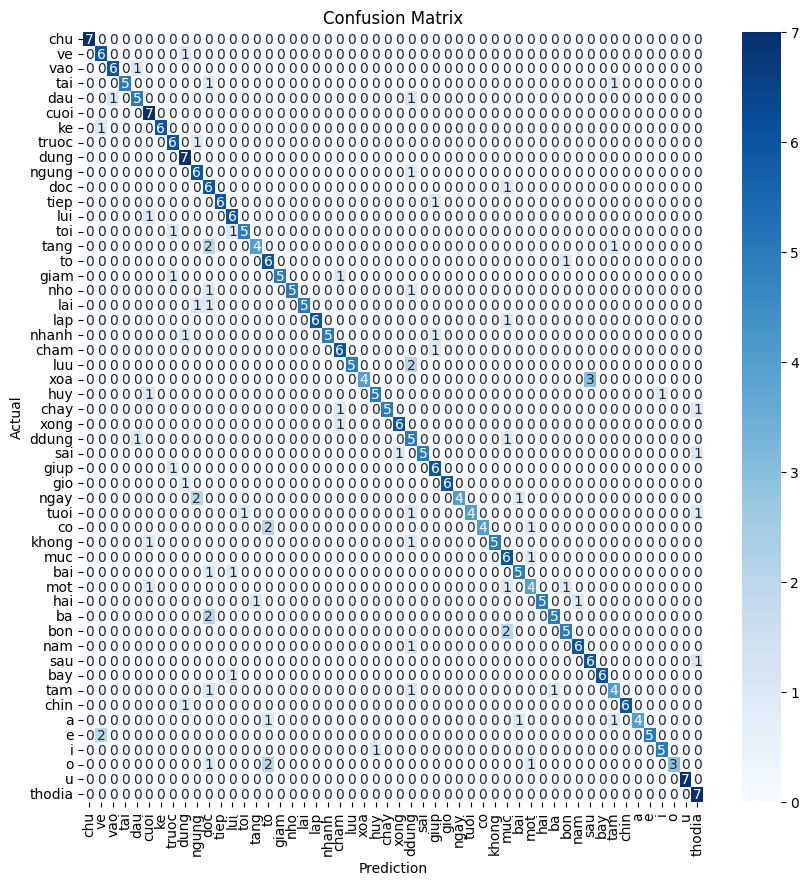

In [494]:
evaluation(models, X, y, class_names)

In [495]:
def save_model(models: dict, class_names, model_path: str, n_states: int, n_mix: int):
    # Xây dựng tên thư mục lưu trữ dựa trên n_states và n_mix
    model_key = f"n_states_{n_states}_n_mix_{n_mix}"
    model_dir = f"{model_path}/{model_key}"
    
    print(f'Saving models to {model_dir}')
    
    # Tạo thư mục nếu chưa tồn tại
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Lưu từng mô hình
    for cname in class_names:
        model_file = f"{model_dir}/model_{cname}.pkl"
        with open(model_file, 'wb') as file:
            pickle.dump(models[cname], file)
    
    # Lưu thông tin tham số vào params.json
    params_file = f"{model_dir}/params.json"
    print(f'Saving parameters to {params_file}')
    with open(params_file, 'w') as file:
        json.dump({
            'n_states': n_states,
            'n_mix': n_mix,
        }, file)

In [496]:
# save_model(models, class_names, model_path, n_states, n_mix)